In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from imblearn.over_sampling import SMOTE

# Load dataset
df = pd.read_csv("/folder/pattern_dataset/diabetes_data.csv")
# Remove duplicate rows
df = df.drop_duplicates()
print("New dataset shape (Diabetic only):", df.shape)

New dataset shape (Diabetic only): (229781, 22)


In [2]:
X = df.drop(columns=["Diabetes_012"])
y = df["Diabetes_012"]

smote = SMOTE(random_state=42)
X_trainres,y_trainres = smote.fit_resample(X,y)
y_trainres.value_counts()

g:\folder\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "g:\folder\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "G:\Softwares\python\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "G:\Softwares\python\Lib\subprocess.py", line 1036, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    

Diabetes_012
0.0    190055
2.0    190055
1.0    190055
Name: count, dtype: int64

In [3]:
df = pd.concat([X,y],axis=1)

In [4]:
# New features
df["HypertensionRisk"] = df["HighBP"] + df["HighChol"]  # Risk factor combining BP & cholesterol
df["PhysicalHealthScore"] = df["PhysHlth"] + df["DiffWalk"]  # Mobility risk factor

# Target variable: Predicting **ANY** major health risk (Stroke, Heart Disease)
df["Complication_Risk"] = df.apply(lambda row: 1 if row["HeartDiseaseorAttack"] == 1 or row["Stroke"] == 1 else 0, axis=1)

# Drop **directly correlated features** to prevent leakage
df.drop(columns=["HeartDiseaseorAttack", "Stroke"], inplace=True)


In [5]:
X = df.drop(columns=["Complication_Risk"])  
y = df["Complication_Risk"]  

In [10]:
y.value_counts()
smote = SMOTE(random_state=42, sampling_strategy='minority')
X_trainres,y_trainres = smote.fit_resample(X,y)
y_trainres.value_counts()

Complication_Risk
0    199716
1    199716
Name: count, dtype: int64

In [11]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_trainres, y_trainres, test_size=0.2, random_state=42, stratify=y_trainres)

In [13]:
# Remove SVM from models dictionary to reduce execution time
models = {
    "Logistic Regression": LogisticRegression(class_weight="balanced", max_iter=500),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, class_weight="balanced"),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(max_depth=8, class_weight="balanced")
}

results = {}
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")  # Track progress
    model.fit(X_trainres, y_trainres)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    results[model_name] = acc
    
    print(f"\n{model_name} Accuracy: {acc:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))



Training Logistic Regression...

Logistic Regression Accuracy: 0.7612
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.73      0.75     39944
           1       0.75      0.79      0.77     39943

    accuracy                           0.76     79887
   macro avg       0.76      0.76      0.76     79887
weighted avg       0.76      0.76      0.76     79887


Training Random Forest...

Random Forest Accuracy: 0.8845
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.89      0.88     39944
           1       0.89      0.88      0.88     39943

    accuracy                           0.88     79887
   macro avg       0.88      0.88      0.88     79887
weighted avg       0.88      0.88      0.88     79887


Training Naive Bayes...

Naive Bayes Accuracy: 0.7301
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.68 

In [14]:
# Identify the best-performing model
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

print(f"Best Performing Model: {best_model_name} with Accuracy: {results[best_model_name]:.4f}")

Best Performing Model: Random Forest with Accuracy: 0.8845


C:\Users\mrgad\AppData\Local\Temp\ipykernel_23780\3671506039.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=list(results.values()), palette="coolwarm")


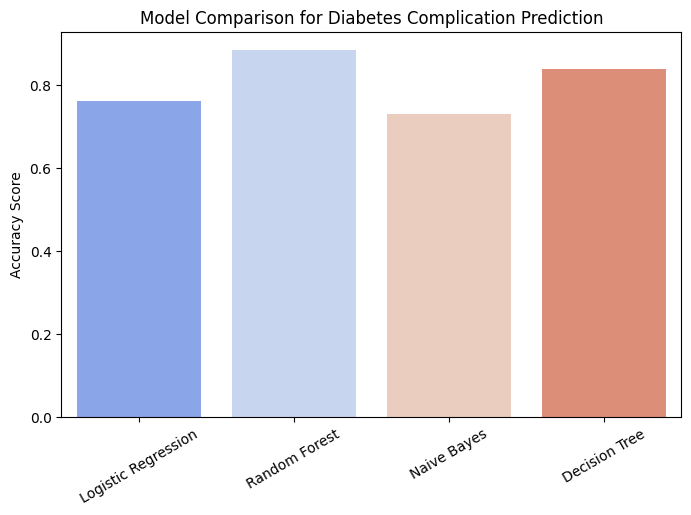

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar plot of model accuracies
plt.figure(figsize=(8, 5))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette="coolwarm")
plt.title("Model Comparison for Diabetes Complication Prediction")
plt.xticks(rotation=30)
plt.ylabel("Accuracy Score")
plt.show()

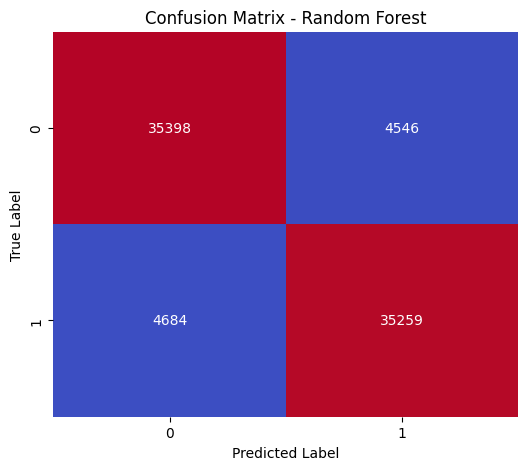

In [16]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix for the best model
y_pred_best = best_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_best)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", cbar=False)
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

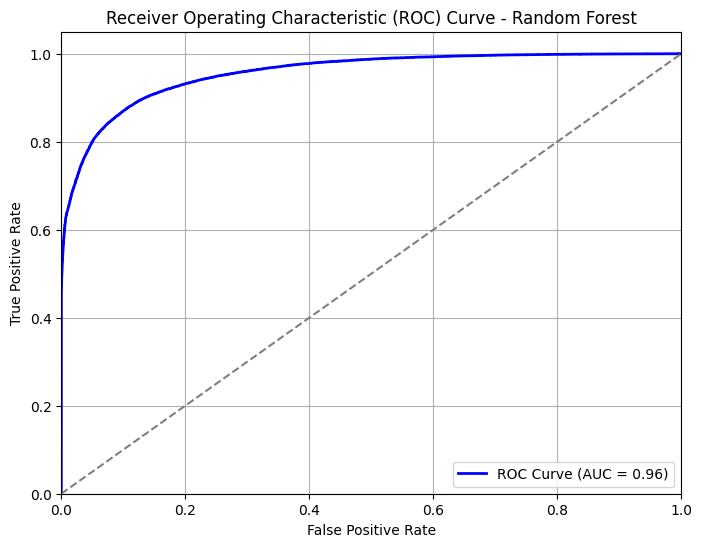

In [17]:
from sklearn.metrics import roc_curve, auc

# Get probability scores for positive class
y_scores_best = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_test, y_scores_best)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal reference line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curve - {best_model_name}')
plt.legend(loc="lower right")
plt.grid()
plt.show()